In [86]:
import datetime
import time

# for data handeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for the model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

# for API handeling
import requests
import json
from datetime import datetime
import pytz

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/requests/__init__.py:78: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({0}) or chardet ({1}) doesn't match a supported "


In [61]:
root = ""
data_2017 = pd.read_csv(root+"3063829_21.17_72.82_2017.csv");
data_2018 = pd.read_csv(root+"3063829_21.17_72.82_2018.csv");
data_2019 = pd.read_csv(root+"3063829_21.17_72.82_2019.csv");
irr_volt_data = pd.read_csv(root+"datasolar.csv")
irr_power_data = pd.read_csv(root+"matdata.csv")

In [10]:
combined_data = pd.concat([data_2017, data_2018, data_2019], axis=0).reset_index(drop=True)

In [37]:
combined_data['date_time'] = combined_data['Year'].astype('string')+'/'+combined_data['Month'].astype('string')+'/'+combined_data['Day'].astype('string')+" "++combined_data['Hour'].astype('string')+":"++combined_data['Minute'].astype('string')

In [38]:
combined_data

,Year,Month,Day,Hour,Minute,Temperature,DHI,Wind Speed,Pressure,Wind Direction,GHI,DNI,Relative Humidity,date_time
0,2017,1,1,0,30,19.0,0,1.5,1012,96,0,0,67.73,2017/1/1 0:30
1,2017,1,1,1,30,19.2,0,1.5,1013,91,0,0,64.43,2017/1/1 1:30
2,2017,1,1,2,30,20.8,54,1.8,1014,87,87,225,56.83,2017/1/1 2:30
3,2017,1,1,3,30,23.4,116,1.9,1014,67,287,494,46.23,2017/1/1 3:30
4,2017,1,1,4,30,26.1,150,2.1,1014,44,478,642,37.10,2017/1/1 4:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,2019,12,31,19,30,17.5,0,2.6,1012,73,0,0,86.23,2019/12/31 19:30
26276,2019,12,31,20,30,17.1,0,2.4,1011,99,0,0,88.14,2019/12/31 20:30
26277,2019,12,31,21,30,16.7,0,2.3,1011,119,0,0,90.91,2019/12/31 21:30
26278,2019,12,31,22,30,16.4,0,2.1,1011,128,0,0,93.50,2019/12/31 22:30


In [48]:
combined_data['UTC'] = combined_data['date_time'].apply(lambda x:datetime.datetime.timestamp(datetime.datetime.strptime(x,
                                                             "%Y/%m/%d %H:%M")))

In [67]:
cols = ['Year',
 'Month',
 'Day',
 'Hour',
 'Minute',
 'Temperature',
 'Wind Speed',
 'Pressure',
 'Wind Direction',
 'Relative Humidity',
 'UTC',
 'GHI']
combined_data = combined_data[cols]

In [54]:
combined_data = combined_data.drop(['DHI','DNI','date_time'],axis = 1)

<AxesSubplot:>

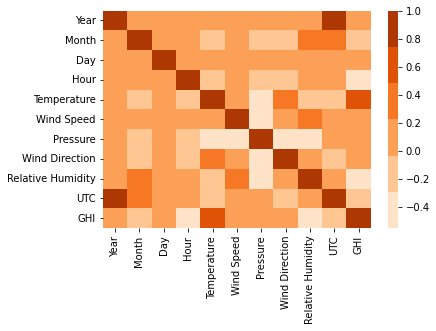

In [68]:
correlation = combined_data.drop('Minute',axis =1).corr(method = 'pearson')
sns.heatmap(correlation, cmap=sns.color_palette("Oranges"))

<AxesSubplot:>

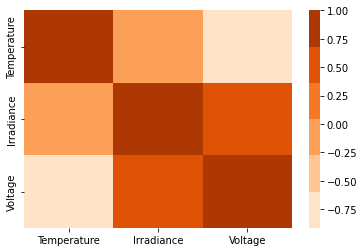

In [69]:
correlation = irr_volt_data.corr(method = 'pearson')
sns.heatmap(correlation, cmap=sns.color_palette("Oranges"))

<AxesSubplot:>

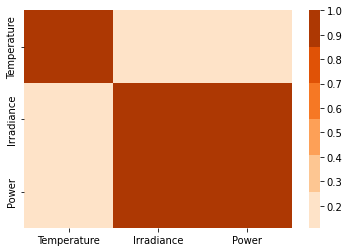

In [70]:
correlation = irr_power_data.corr(method = 'pearson')
sns.heatmap(correlation, cmap=sns.color_palette("Oranges"))

In [179]:
def model_maker(data,key):
    # creating the model.
    regressor = LinearRegression()

    # extracting X and Y from the data.
    df2 = data.iloc[:,:-1]
    X = df2.to_numpy()
    Y = data[key].to_numpy()

    # X_train and Y_train for training the model. X_test, Y_test for testing.
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.80, random_state=1)

    #fitting the model
    regressor.fit(X_train, Y_train)

    # Calcuting the accuracies
    accuracies = cross_val_score(estimator = regressor, X = X_train,y = Y_train, cv = 2, scoring = 'r2')
    accuracy = accuracies.mean()
    print('\n--------------------------------------------------\n')
    print('From Training Data:')
    print(f'r2 = {accuracy}\n')


    # predicting radiance and accuracy calculation
    y_pred = regressor.predict(X_test)
    explained_variance_score2 = explained_variance_score(Y_test, y_pred)
    mean_squared_error2 = mean_squared_error(Y_test, y_pred)
    r_squared = r2_score(Y_test, y_pred)

    
    print('From Testing Data:')
    print(f'explained variance = {explained_variance_score2}')
    print(f'mse = {mean_squared_error2}')
    print(f'r2 = {r_squared}')

    plt.plot(Y_test[:50])
    plt.plot(y_pred[:50])
    plt.show()
    print('\n--------------------------------------------------\n')
    return regressor

In [180]:
combined_data.iloc[:,1:-1]


,Month,Day,Hour,Minute,Temperature,Wind Speed,Pressure,Wind Direction,Relative Humidity,UTC
0,1,1,0,30,19.0,1.5,1012,96,67.73,1.483211e+09
1,1,1,1,30,19.2,1.5,1013,91,64.43,1.483214e+09
2,1,1,2,30,20.8,1.8,1014,87,56.83,1.483218e+09
3,1,1,3,30,23.4,1.9,1014,67,46.23,1.483222e+09
4,1,1,4,30,26.1,2.1,1014,44,37.10,1.483225e+09
...,...,...,...,...,...,...,...,...,...,...
26275,12,31,19,30,17.5,2.6,1012,73,86.23,1.577801e+09
26276,12,31,20,30,17.1,2.4,1011,99,88.14,1.577804e+09
26277,12,31,21,30,16.7,2.3,1011,119,90.91,1.577808e+09
26278,12,31,22,30,16.4,2.1,1011,128,93.50,1.577812e+09



--------------------------------------------------

From Training Data:
r2 = 0.6342793453420029

From Testing Data:
explained variance = 0.6395281701664115
mse = 31734.328642829652
r2 = 0.6395081860655379


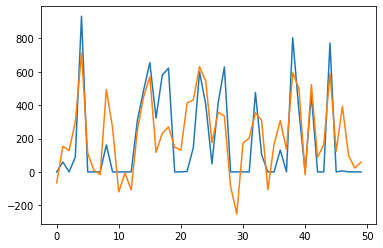


--------------------------------------------------



In [181]:
# creating the models for irradiance and voltage.
irradiance_model = model_maker(combined_data.drop('UTC',axis = 1),'GHI')


--------------------------------------------------

From Training Data:
r2 = 0.9778311866470759

From Testing Data:
explained variance = 0.9762039509053443
mse = 25.992474259978422
r2 = 0.9761229427295558


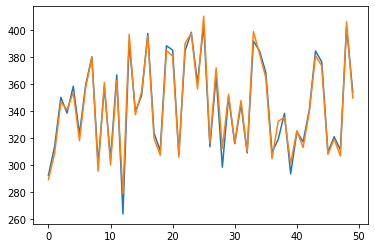


--------------------------------------------------



In [84]:
voltage_model = model_maker(matlab_data,'Voltage')


--------------------------------------------------

From Training Data:
r2 = 0.9999733595110097

From Testing Data:
explained variance = 0.9999071699862887
mse = 1.279531233510361
r2 = 0.9998745923021889


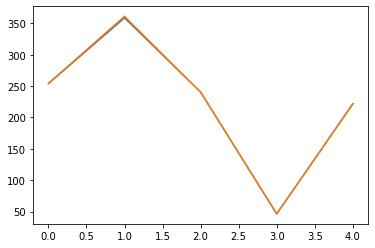


--------------------------------------------------



In [85]:
mat_model = model_maker(matdata,'Power')

In [175]:
def round_minute(hour, min):
    if (min<15 and min>0):
        return hour,0
    elif (min>=15 and min<45):
        return hour, 30
    else:
        return hour+1, 0 
    
# The below function handles the API call.
def API_handler(lat=21.1663287,lon=72.7832836):
    url = "https://api.openweathermap.org/data/2.5/weather?lat="+str(lat)+"&lon="+str(lon)+"&appid=61ad3db633bd7d6485e331462920f750"
    response = requests.get(url)

    if response.status_code == 200:
        print("Sucessfully fetched the data from the API.")
    else:
        print(f"Hello User!, there's a {response.status_code} error with your request. Can not fetch the data.")

    fetched_data = response.json()
    print(fetched_data)

    # print(currTime)
    return np.array([[datetime.now().year,
  datetime.now().month,
  datetime.now().day, 
  round_minute(datetime.now().hour,datetime.now().minute)[0]-5, 
  round_minute(datetime.now().hour,datetime.now().minute)[1],
  fetched_data['main']['temp']-273.15,
  fetched_data['wind']['speed'],
  fetched_data['main']['pressure'],
 fetched_data['wind']['deg'],
 fetched_data['main']['humidity']
 ]])

In [173]:
api_data = API_handler()

Sucessfully fetched the data from the API.
{'coord': {'lon': 72.7833, 'lat': 21.1663}, 'weather': [{'id': 711, 'main': 'Smoke', 'description': 'smoke', 'icon': '50d'}], 'base': 'stations', 'main': {'temp': 307.12, 'feels_like': 306.57, 'temp_min': 307.12, 'temp_max': 307.12, 'pressure': 1013, 'humidity': 31}, 'visibility': 4000, 'wind': {'speed': 3.09, 'deg': 220}, 'clouds': {'all': 83}, 'dt': 1667808503, 'sys': {'type': 1, 'id': 9071, 'country': 'IN', 'sunrise': 1667783678, 'sunset': 1667824226}, 'timezone': 19800, 'id': 1255364, 'name': 'Surat', 'cod': 200}


In [182]:
irr = irradiance_model.predict(api_data)[0]
vol = voltage_model.predict([[api_data[0][-1],irr]])[0]
powe = mat_model.predict([[api_data[0][-1],irr]])[0]

print(f"Irradiance = {irr} and OC Voltage = {vol}")

Irradiance = 710.4920749771481 and OC Voltage = 350.50867411549564
